In [1]:
import os
import glob
import scanpy as sc
import scanpy.external as sce
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from seaborn import despine
from seaborn import axes_style
import magic # imputation tool; van Dijk et al 2018 # 
from matplotlib.pyplot import suptitle
import matplotlib.colors

sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

# Define a color map
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['blue','lightblue','lightgreen','green','yellow','red'])
cmap_zscore = matplotlib.colors.LinearSegmentedColormap.from_list("", ['blue','black','red'])

/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 7.2.0
backcall            0.1.0
cairo               1.19.1
cffi                1.14.0
colorama            0.4.5
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
decorator           4.4.2
deprecated          1.2.7
future              0.18.2
graphtools          1.5.0
h5py                3.7.0
igraph              0.8.2
ipykernel           5.2.0
ipython_genutils    0.2.0
ipywidgets          7.5.1
jedi                0.16.0
joblib              0.14.1
kiwisolver          1.1.0
leidenalg           0.7.0
llvmlite            0.31.0
louvain             0.6.1
magic               2.0.3
matplotlib          3.5.2
mpl_toolkits        NA
natsort             7.0.1
numba               0.48.0
numexpr             2.7.1
numpy               1.22.4
packaging           20.3
pandas              1.5.3
parso               0.6.2
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
prompt_toolkit   

### Pre processing

The following h5 files were used for analysis:['/n/data2/bch/hemonc/ckim/AARON/20190715_KPY_timecourse/data_analysis/h5_files/10weeksCD31_AM21_filtered_feature_bc_matrix.h5', '/n/data2/bch/hemonc/ckim/AARON/20190715_KPY_timecourse/data_analysis/h5_files/10weeksCD45_AM22_filtered_feature_bc_matrix.h5', '/n/data2/bch/hemonc/ckim/AARON/20190715_KPY_timecourse/data_analysis/h5_files/10weeksMES_AM20_filtered_feature_bc_matrix.h5', '/n/data2/bch/hemonc/ckim/AARON/20190715_KPY_timecourse/data_analysis/h5_files/10weeksYFP_AM19_filtered_feature_bc_matrix.h5', '/n/data2/bch/hemonc/ckim/AARON/20190715_KPY_timecourse/data_analysis/h5_files/16weeksCD31_AM25_filtered_feature_bc_matrix.h5', '/n/data2/bch/hemonc/ckim/AARON/20190715_KPY_timecourse/data_analysis/h5_files/16weeksCD45_AM26_filtered_feature_bc_matrix.h5', '/n/data2/bch/hemonc/ckim/AARON/20190715_KPY_timecourse/data_analysis/h5_files/16weeksMES_AM24_filtered_feature_bc_matrix.h5', '/n/data2/bch/hemonc/ckim/AARON/20190715_KPY_timecourse/data

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Vari

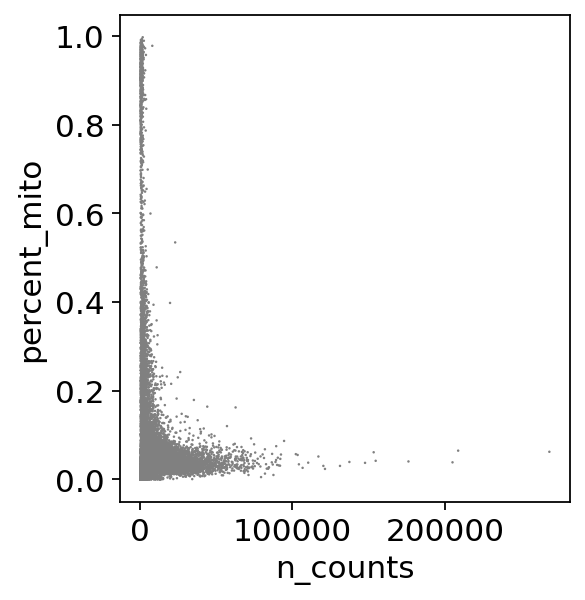

In [3]:
h5_path = 'path/to/h5ad'

filenames_input = glob.glob('%s/*.h5'%h5_path)

filenames = sorted(filenames_input) # sort in alphabetical order

print('The following h5 files were used for analysis:%s'%filenames)

categories = []

for files in os.listdir(h5_path):
    if files.endswith(".h5"):
        category = files.split(',')[0].split('_')
        categories.append(category) # turns files names into list of lists

extracted_batch_categories = [categories[i][0] for i in range(len(categories))] # extract file names
# https://www.codecademy.com/forum_questions/54f231c876b8fe4269002f2f

extracted_batch_categories.sort() # sort names in alphabetical order

adatas = [sc.read_10x_h5(filename) for filename in filenames]

adata = adatas[0].concatenate(adatas[1:], batch_categories = extracted_batch_categories) # merge files into anndata object

adata.var_names_make_unique() # make gene names unique

# compute %mito and remove cells with >10%
mito_genes = adata.var_names.str.startswith('mt-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

# plot mitochondrial content (y-axis) against read count before and after filtering cells with > 10% mitochondrial gene expression
# Cells wth >10% mito expression also has low read count indicating bad/dead cells rather than cells requiring more energy
sc.settings.set_figure_params(dpi=80)
with axes_style({'axes.grid': False}):
 sc.pl.scatter(adata, y='percent_mito', x='n_counts', size=5)

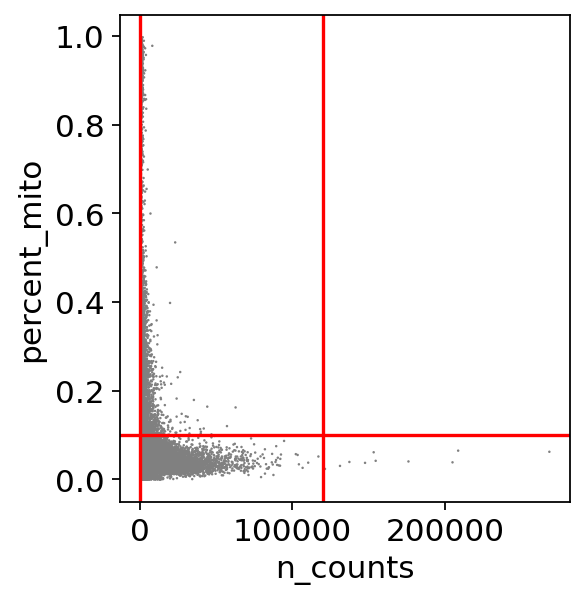

In [4]:
sc.settings.set_figure_params(dpi=80)
with axes_style({'axes.grid': False}):
 sc.pl.scatter(adata, y='percent_mito', x='n_counts', size=5, show = False)
 plt.axvline(120000, color='red')
 plt.axvline(200, color='red')
 plt.axhline(0.1, color='red')

In [5]:
adata = adata[adata.obs['percent_mito'] < 0.1, :]
adata = adata[adata.obs['n_counts'] < 120000, :]
adata = adata[adata.obs['n_counts'] > 200, :]
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_genes(adata, min_counts=1)

Trying to set attribute `.var` of view, copying.


In [6]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
adata.raw = adata

In [7]:
adata.obs['Foxj1']=adata[:, ['Foxj1']].to_df()
adata.obs['Cd24a']=adata[:, ['Cd24a']].to_df()
adata.obs['Scgb1a1']=adata[:, ['Scgb1a1']].to_df()
adata.obs['Scgb3a2']=adata[:, ['Scgb3a2']].to_df()

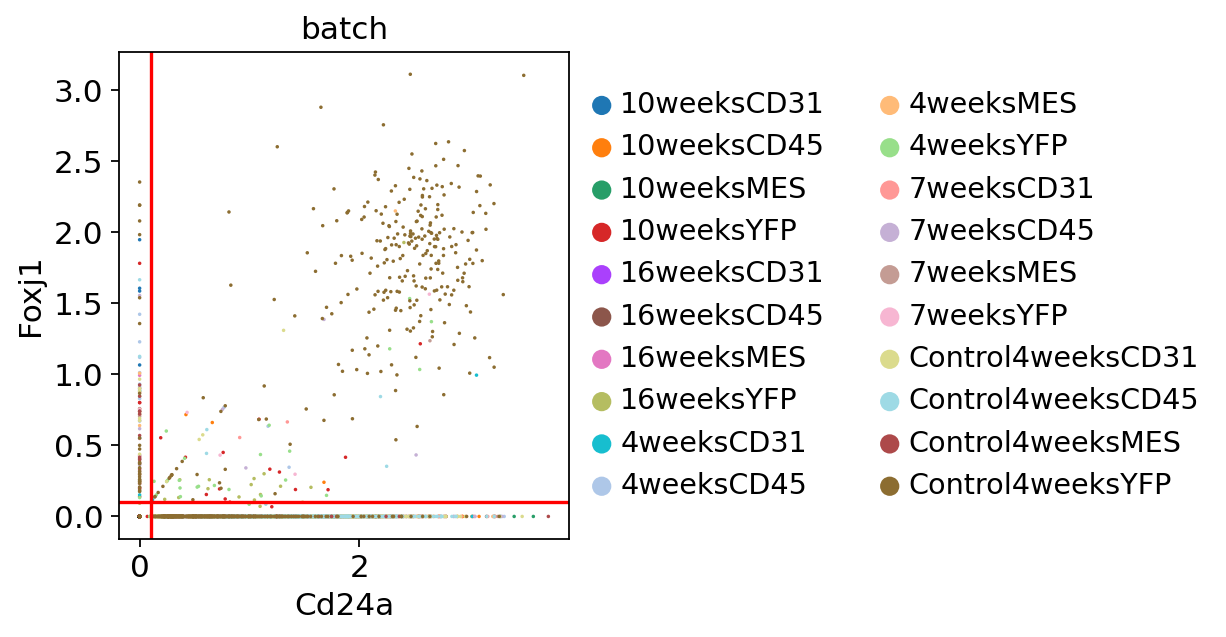

In [8]:
with axes_style({'axes.grid': False}):
    sc.pl.scatter(adata, y='Foxj1', x='Cd24a', color='batch', size=10, show = False)
    plt.axvline(0.1, color='red')
    plt.axhline(0.1, color='red')

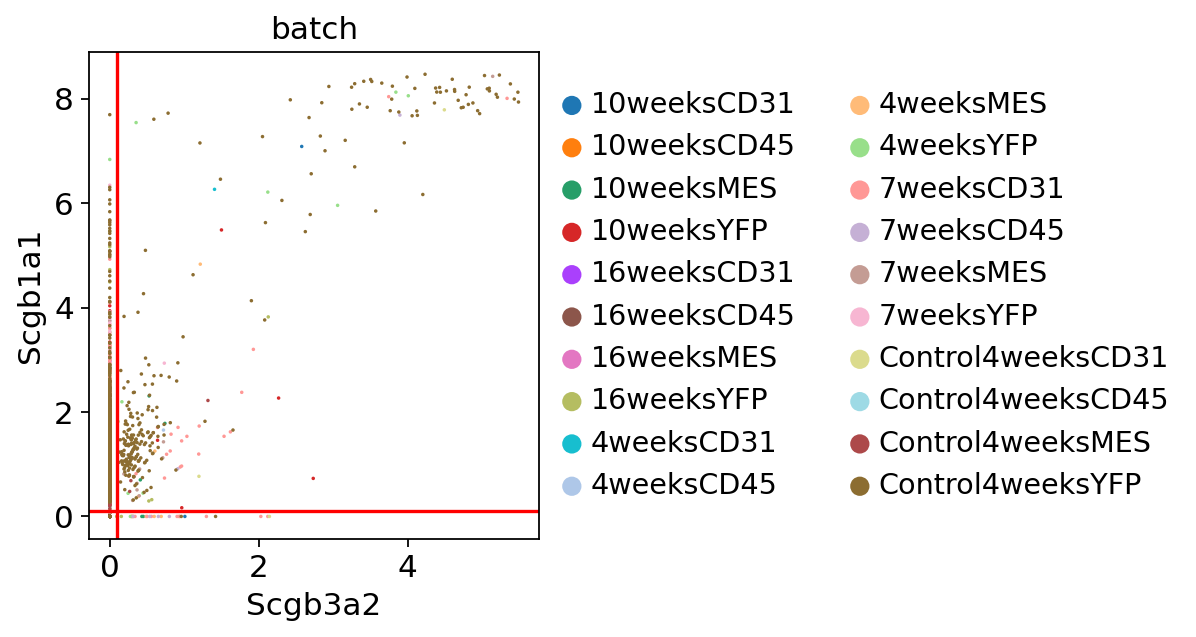

In [9]:
with axes_style({'axes.grid': False}):
    sc.pl.scatter(adata, y='Scgb1a1', x='Scgb3a2', color='batch', size=10, show = False)
    plt.axvline(0.1, color='red')
    plt.axhline(0.1, color='red')

In [10]:
# Annotate based on sorting group
scores = adata.obs[['batch','Cd24a','Foxj1','Scgb1a1','Scgb3a2']]

control_annotation = pd.Series('Keep', index=scores.index)

control_annotation[(scores.Foxj1 > 0.1) & (scores.Cd24a > 0.1) & (scores.batch == 'Control4weeksYFP')] = 'Ciliated cells'
control_annotation[(scores.Scgb1a1 > 0.1) & (scores.Scgb3a2 > 0.1) & (scores.batch == 'Control4weeksYFP')] = 'Club cells'  
adata.obs['Cells_to_keep'] = control_annotation

... storing 'Cells_to_keep' as categorical


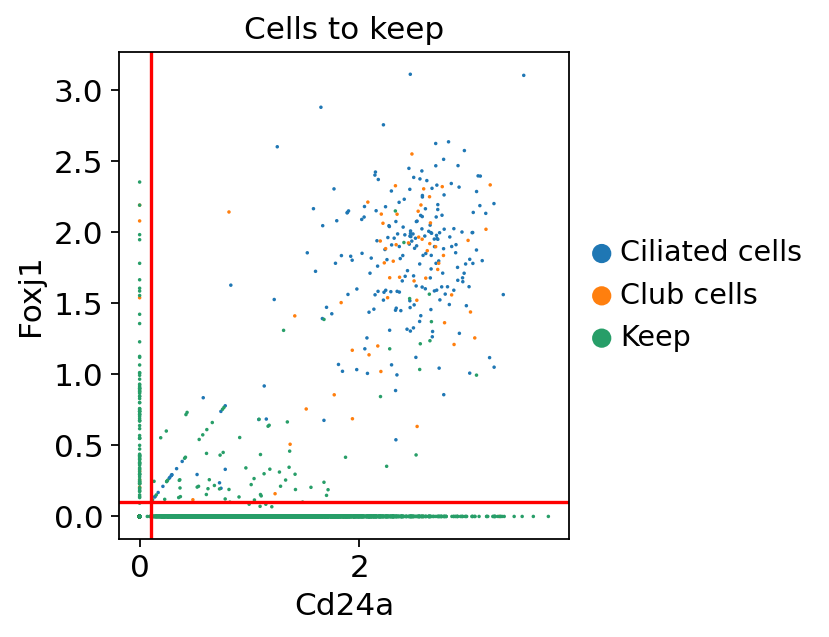

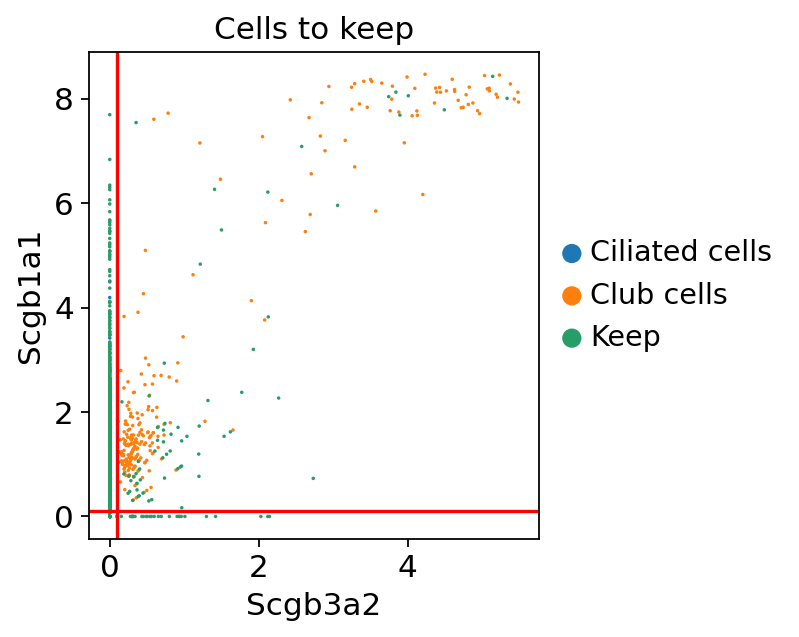

In [11]:
with axes_style({'axes.grid': False}):
    sc.pl.scatter(adata, y='Foxj1', x='Cd24a', color='Cells_to_keep', size=10, show = False)
    plt.axvline(0.1, color='red')
    plt.axhline(0.1, color='red')
    
with axes_style({'axes.grid': False}):
    sc.pl.scatter(adata, y='Scgb1a1', x='Scgb3a2', color='Cells_to_keep', size=10, show = False)
    plt.axvline(0.1, color='red')
    plt.axhline(0.1, color='red')

In [12]:
len(adata.obs.index) # cells before control club/ciliated filtering

20271

In [13]:
adata = adata[adata.obs['Cells_to_keep'].isin(['Keep'])]

In [14]:
len(adata.obs.index) # cells after control club/ciliated filtering

19784

Save at this point

In [15]:
results_file = '/n/data2/bch/hemonc/ckim/AARON/20190715_KPY_timecourse/data_analysis/scanpy_analysis/write/adata.h5ad'
adata.write(results_file)

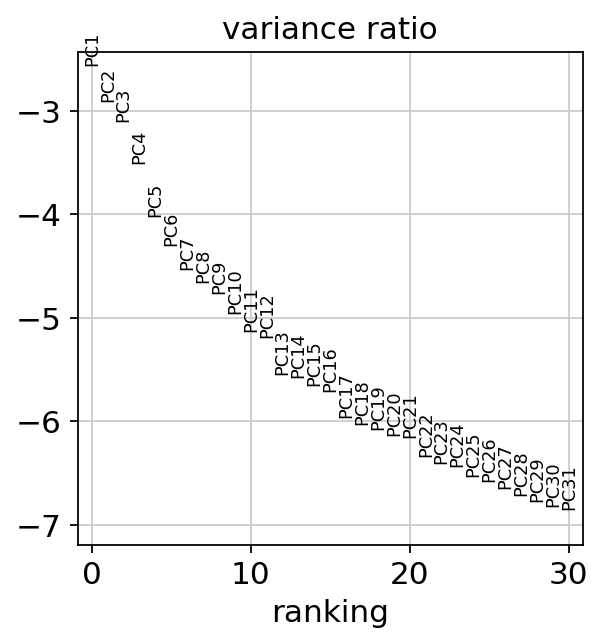

In [16]:
sc.tl.pca(adata, svd_solver='arpack') # svd_solver='arpack' is important for reproducibility
sc.pl.pca_variance_ratio(adata, log = True) 

In [17]:
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=30)

/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/numba/typed_passes.py:292: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,
/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/umap/nndescent.py:91: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/

Define groups for subseting

Cell type

In [18]:
scores = adata.obs[['batch']]

annotation = pd.Series('Error!', index=scores.index)

annotation[(scores.batch == 'Control4weeksYFP')|(scores.batch == '4weeksYFP')|(scores.batch == '7weeksYFP')|(scores.batch == '10weeksYFP')|(scores.batch == '16weeksYFP')] = 'Epithelium' 
annotation[(scores.batch == 'Control4weeksCD45')|(scores.batch == '4weeksCD45')|(scores.batch == '7weeksCD45')|(scores.batch == '10weeksCD45')|(scores.batch == '16weeksCD45')] = 'Immune' 
annotation[(scores.batch == 'Control4weeksMES')|(scores.batch == '4weeksMES')|(scores.batch == '7weeksMES')|(scores.batch == '10weeksMES')|(scores.batch == '16weeksMES')] = 'Mesenchyme'
annotation[(scores.batch == 'Control4weeksCD31')|(scores.batch == '4weeksCD31')|(scores.batch == '7weeksCD31')|(scores.batch == '10weeksCD31')|(scores.batch == '16weeksCD31')] = 'Endothelium'

adata.obs['cell_type'] = annotation

Time point

In [19]:
scores = adata.obs[['batch']]

annotation = pd.Series('Error!', index=scores.index)

annotation[(scores.batch == 'Control4weeksYFP')|(scores.batch == 'Control4weeksCD31')|(scores.batch == 'Control4weeksCD45')|(scores.batch == 'Control4weeksMES')] = 'Control_4weeks' 
annotation[(scores.batch == '4weeksYFP')|(scores.batch == '4weeksCD31')|(scores.batch == '4weeksCD45')|(scores.batch == '4weeksMES')] = '4weeks' 
annotation[(scores.batch == '7weeksYFP')|(scores.batch == '7weeksCD31')|(scores.batch == '7weeksCD45')|(scores.batch == '7weeksMES')] = '7weeks' 
annotation[(scores.batch == '10weeksYFP')|(scores.batch == '10weeksCD31')|(scores.batch == '10weeksCD45')|(scores.batch == '10weeksMES')] = '10weeks' 
annotation[(scores.batch == '16weeksYFP')|(scores.batch == '16weeksCD31')|(scores.batch == '16weeksCD45')|(scores.batch == '16weeksMES')] = '16weeks' 

adata.obs['time_point'] = annotation

In [20]:
sc.tl.umap(adata)

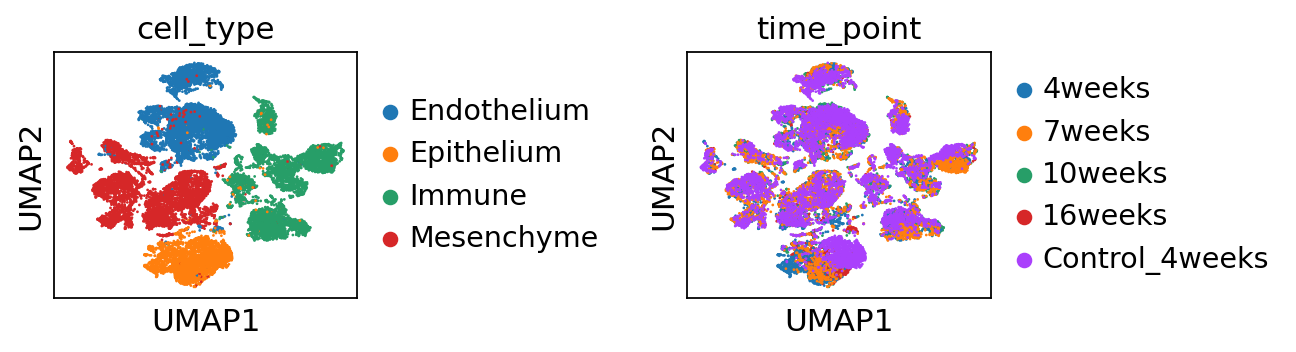

In [8]:
rcParams['figure.facecolor']='white'
rcParams['figure.figsize']=2,2
sc.pl.umap(adata, color=['cell_type','time_point'], wspace=0.9, frameon=True)

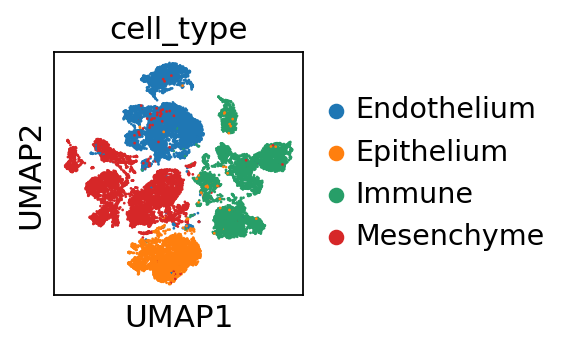

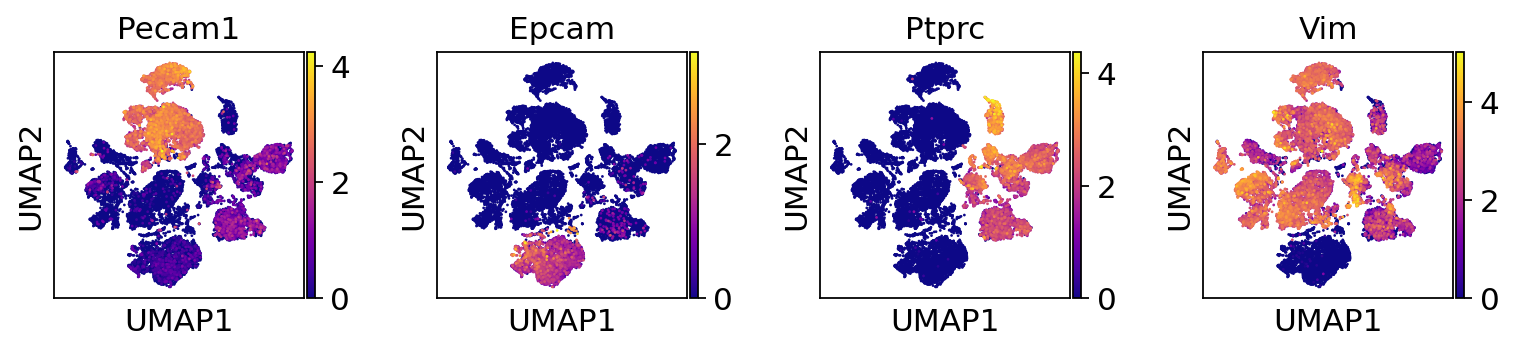

In [7]:
rcParams['figure.facecolor']='white'
rcParams['figure.figsize']=2,2
sc.pl.umap(adata, color=['cell_type'], wspace=0.9, frameon=True)
sc.pl.umap(adata, color=['Pecam1','Epcam','Ptprc','Vim'], cmap='plasma', vmin=0, frameon=True) # known generic markers

In [9]:
len(adata.obs.index)

19784

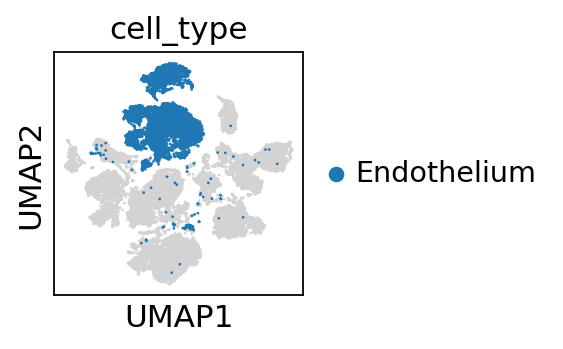

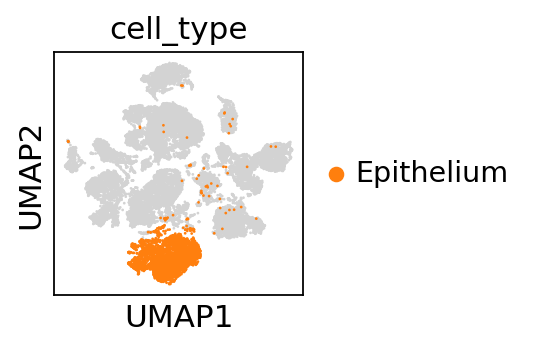

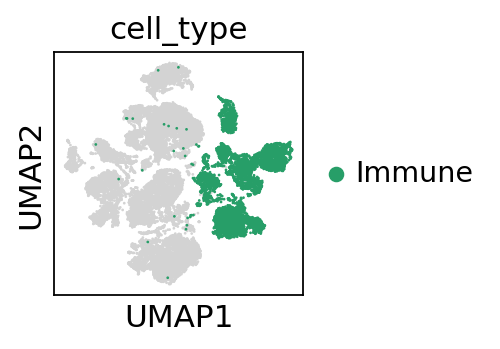

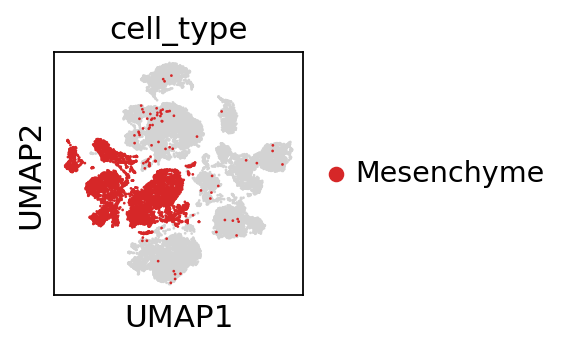

In [11]:
cellType = sorted(list(set(adata.obs['cell_type'])))

for cell in cellType:
    rcParams["figure.facecolor"]='white'
    rcParams['figure.figsize']=2,2   
    sc.pl.umap(adata, color=['cell_type'], groups=cell)

In [12]:
adata.obs['cell_type'].value_counts()

Endothelium    5753
Immune         5465
Mesenchyme     5441
Epithelium     3125
Name: cell_type, dtype: int64